# Import packages

In [1]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import orth
import time

from sca.models import fit_sca, weighted_pca, weighted_rrr
from sca.util import get_sample_weights

/opt/anaconda3/envs/ssa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %load_ext autoreload
# %autoreload 2

# Simulate data

In [3]:
#Function that creates a sine wave for a given amount of time (T),
#where the number of cycles (c) occurs during that time
def create_sine(T,c):
    tau=T/(2*np.pi)/c
    return np.sin(np.arange(0,T)/tau)

#### Generate the simulated data X0 (size [Time x Num_neurons1]) and Y0 (size [Time x Num_neurons2])

In [4]:
np.random.seed(0) #To get the same simulated data

T=1200 #Time
N1=50 #Number of neurons in population 1
N2=60 #Number of neurons in population 2
R_shared=3 #Number of shared dimensions in lowD representations
R1=3 #Number of unshared dimensions in lowD representation of pop 1
R2=3 #Number of unshared dimensions in lowD representation of pop 2


#Orthogonal matrix that projects low dimensional space to full neural space of pop1
U_tmp=orth(npr.randn(R_shared+R1,N1).T).T 

#Orthogonal matrix that projects low dimensional space to full neural space of pop2
V_tmp=orth(npr.randn(R_shared+R2,N2).T).T 

#Create shared low dimensional space
Z_shared=np.zeros([T,R_shared])
for i in range(R_shared):
    Z_shared[300*i:300*i+500,i]=create_sine(500,i+1)

#Create low dimensional spaces unique to each population
Zx=npr.randn(T,R1)
Zy=npr.randn(T,R2)
    
#Create high-dimensional neural activity    
b1=npr.randn(N1) #Offset of neurons
b2=npr.randn(N2) #Offset of neurons

X0=Z_shared@U_tmp[:R_shared]+Zx@U_tmp[R_shared:]+b1 #Project into high-dimensional space and add offset
Y0=Z_shared@V_tmp[:R_shared]+Zy@V_tmp[R_shared:]+b2 #Project into high-dimensional space and add offset

# X0=X0+.1*npr.randn(X0.shape[0],X0.shape[1]) #Add noise
# Y0=Y0+.1*npr.randn(Y0.shape[0],Y0.shape[1]) #Add noise

# Preprocess data (optional)

I have found that the method usually works better when zero-centering the data.

In this specific example, if you don't zero-center the data, it will take ~5000 iterations to converge to the ground truth, rather than ~2000.

In [5]:
# X=np.copy(X0)
# Y=np.copy(Y0)


X=np.copy(X0-np.mean(X0,axis=0)[None,:])
Y=np.copy(Y0-np.mean(Y0,axis=0)[None,:])

# Set required model parameters

In [6]:
#Number of shared dimensions in the low-D model you're fitting
R_est=4

# Set optional model parameters

All of these have default values, so it's not essential to set them. The values listed below are the default values.

In [7]:
#Number of epochs of model fitting
n_epochs=3000

#Learning rate of model fitting
lr=.001


#I would recommend using the default lambda parameters, at least to start. 
#When running SCA, it will print what the default values are for the given dataset

#Strength of the sparsity penalty
lam_sparse=.1

#Strength of the orthogonality penality (Note - This is only used in the version without a hard orthogonality constraint)
lam_orthog=1

#Initialization of weights - can be 'rrr' or 'rand'
init='rrr'

In [8]:
#How much to weight each data point in time
#(this can be helpful for making sure dimensions still aim to explain time points with low activity)

sample_weights=np.ones([X.shape[0],1]) #Weight equally

# sample_weights=get_sample_weights(Y) #Weight inversely to norm of activity at each time point

# Fit Reduced Rank Regression Model (for comparison)

In [9]:
#Fit weighted RRR
#Note that this function does not automatically subtract the mean from the data
__, U_est_rrr,V_est_rrr,b_rrr = weighted_rrr(X,Y,R_est,sample_weights)

#Get the low dimensional representation (the principal components)
rrr_latent = X@U_est_rrr

# Fit SCA Model

Using device cpu


100%|██████████| 3000/3000 [00:03<00:00, 892.68it/s]


Text(0.5, 1.0, 'Loss over training')

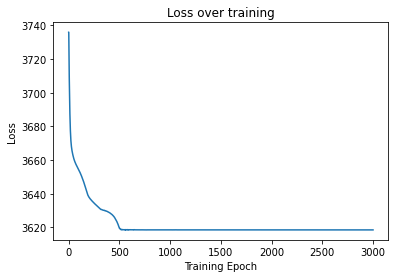

In [10]:
#Fit SCA with orthogonality constraint without all the optional parameters
# model, latent, y_pred, losses = fit_sca(X=X,Y=Y,R=R_est)

#Fit SCA with orthogonality constraint
# model, latent, y_pred, losses = fit_sca(X=X,Y=Y,R=R_est,sample_weight=sample_weights,lam_sparse=lam_sparse,lr=lr,n_epochs=n_epochs,init=init)

#Fit SCA with orthogonality penalty (rather than constraint) without all the optional parameters
model, latent, y_pred, losses = fit_sca(X=X,Y=Y,R=R_est,orth=False)

#Fit SCA with orthogonality penalty (rather than constraint)
# model, latent, y_pred, losses = fit_sca(X=X,Y=Y,R=R_est,orth=False,sample_weight=sample_weights,lam_sparse=lam_sparse,lr=lr,n_epochs=n_epochs,lam_orthog=lam_orthog,init=init)



#Get the low dimensional representation
sca_latent=latent.detach().numpy()



#Plot the loss over all iterations
plt.figure()
plt.plot(losses)
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Loss over training')

#Plot the loss over the last 100 iterations (to see if it has truly hit a plateau)
# plt.figure()
# plt.plot(losses[-100:-1])
# plt.xlabel('Training Epoch')
# plt.ylabel('Loss')

In [11]:
losses[-1]

3618.471435546875

# Plot results

### Plot unordered lowD representations

Text(0.5, 1.0, 'RRR LowD Projections')

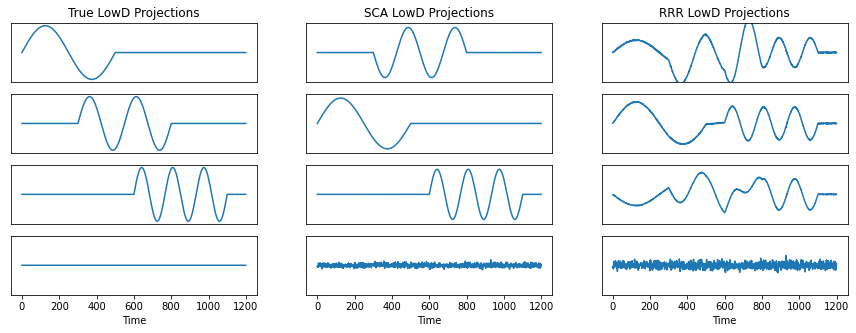

In [12]:
#Ground truth
Z_extra=np.zeros([T,R_est])
Z_extra[:,:R_shared]=Z_shared


plt.figure(figsize=(15,5))
for i in range(R_est):
    
    #Plot ground truth
    plt.subplot(R_est,3,3*i+1)
    plt.plot((Z_extra)[:,i]) 
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
    
    # Plot SCA results
    plt.subplot(R_est,3,3*i+2)
    plt.plot(sca_latent[:,i])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(R_est,3,3*i+3)
    plt.plot(rrr_latent[:,i])
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_est-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')        

#Titles
plt.subplot(R_est,3,1)
plt.title('True LowD Projections')

plt.subplot(R_est,3,2)
plt.title('SCA LowD Projections')

plt.subplot(R_est,3,3)
plt.title('RRR LowD Projections')
